In [1]:
from pandas import read_csv, DataFrame,concat,notnull,isnull,Series,IndexSlice,read_excel
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [15]:
2*3*2*500

6000

In [2]:
cba = read_csv("data_cba/cba_no_flood_million_rs_per_ha.csv")

In [3]:
cba[['min','max']]=cba[['min','max']]*2300*10**(-3)

In [5]:
cba

,option,min,max
0,wetland with no recreation,2.3,13.8
1,wetland with recreation,6.9,23.0
2,lake,6.9,11.5
3,land,34.5,43.7


In [4]:
uncert_var = DataFrame(columns=["var","min","max"])
uncert_var.loc[len(uncert_var),:]=["pop_gr",0,0.03]
uncert_var.loc[len(uncert_var),:]=["gdp_gr",0,0.07]
uncert_var.loc[len(uncert_var),:]=["losses_share",0.05,0.3]
uncert_var.loc[len(uncert_var),:]=["resilience",0.4,0.8]
uncert_var.loc[len(uncert_var),:]=["benef_wetlands",cba.ix[cba.option=="wetland with recreation","min"].values[0],\
                                   cba.ix[cba.option=="wetland with recreation","max"].values[0]]
uncert_var.loc[len(uncert_var),:]=["benef_land",cba.ix[cba.option=="land","min"].values[0],\
                                   cba.ix[cba.option=="land","max"].values[0]]
uncert_var.loc[len(uncert_var),:]=["sh_soc",0.1,1]
uncert_var.loc[len(uncert_var),:]=["scarcity",1,2]

In [33]:
from pyDOE import *
lhsample= lhs(len(uncert_var),samples=1000,criterion="corr")

new candidate solution found with max,abs corrcoef = 0.9930514513661101
new candidate solution found with max,abs corrcoef = 0.987271737724729


In [164]:
scenarios=lhsample*np.diff(uncert_var[['min','max']].values).T+uncert_var['min'].values
scenarios=DataFrame(scenarios,columns=uncert_var['var'])

In [34]:
scenarios.to_csv("scenarios.csv")

In [35]:
from analyze_results_functions import *

gdp_per_capita_2009=47783*12 #based on census
gdp_per_capita_2013=gdp_per_capita_2009*1.075**4 #based on census
ini_pop=2.3*10**6

subdata=load_data(varin1,varin2)
subdata=prepare_data(subdata)

endyear=2030
urban_policy = 0

alllosses=DataFrame()
for scenar in range(len(scenarios)):
    pop_multiplier=2.8*scenarios.loc[scenar,"losses_share"]
    nb_people_exposed=(1+scenarios.loc[scenar,"pop_gr"])**(endyear-2013)*ini_pop
    R=(1+scenarios.loc[scenar,"gdp_gr"])**(endyear-2013)*gdp_per_capita_2013*nb_people_exposed
    
    mult = (1+scenarios.loc[scenar,"pop_gr"])**(endyear-2013)*gdp_per_capita_2013*\
    (1+scenarios.loc[scenar,"gdp_gr"])**(endyear-2013)*pop_multiplier
    subdata["costestimated"] = subdata['popestimated']*mult

    losses          = calc_annual_losses(subdata,R)
    losses["annuallosses"] = losses["annuallosses"]/scenarios.loc[scenar,"resilience"]
    for s in scenarios.columns:
        losses.loc[:,s]=scenarios.loc[scenar,s]
    alllosses=alllosses.append(losses,ignore_index=True)

alllosses.to_csv("all_economic_losses_{}.csv".format(endyear),index=False)

In [5]:
endyear=2030

In [6]:
alllosses = read_csv("all_economic_losses_{}.csv".format(endyear))

In [7]:
#losses = read_csv("all_economic_losses_2030.csv")
alllosses["wetland_preserv"]=100-alllosses["wetland_loss"]
alllosses = alllosses.drop("wetland_loss",axis=1)

In [8]:
indx1 = ['climate_change', 'runoff', 'bndconditions','pop_gr', 'gdp_gr', 'losses_share', 'resilience',\
         'sh_soc', 'scarcity','benef_wetlands', 'benef_land']
indx2 = indx1+['wetland_preserv']

In [9]:
c = (alllosses.drop(["scenario_number"],axis=1).set_index(indx1) - \
 alllosses.drop(["scenario_number"],axis=1).query('wetland_preserv==0').set_index(indx1)).reset_index().set_index(indx2).rename(columns={"annuallosses":"diffannuallosses"})

new_losses = concat([alllosses.set_index(indx2),-c],axis=1).reset_index()

In [10]:
new_losses["benef"]=new_losses.diffannuallosses+1/100*new_losses.wetland_preserv*\
                                   new_losses.benef_wetlands*((1+new_losses.gdp_gr)**(endyear-2013))
new_losses["cost"] = new_losses.sh_soc*1/100*new_losses.wetland_preserv*\
                                   new_losses.benef_land*((1+new_losses.gdp_gr/new_losses.scarcity)**(endyear-2013))
new_losses["npv"] = new_losses["benef"]-new_losses["cost"]

In [11]:
jojo=new_losses.set_index(indx2).npv.unstack("wetland_preserv")
zz = jojo.apply(lambda s:s-jojo.max(axis=1))
regret = zz.stack().reset_index().rename(columns={0:"regret"})

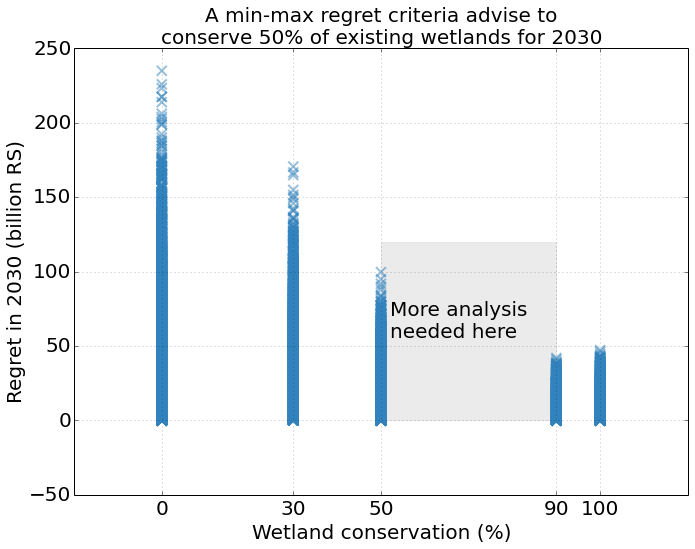

In [19]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(11,8))

ax=plt.subplot(111)

#select = (regret.GDPgr==0)&(regret.Popgr==0)&(regret.urban_policy==0)&(regret.climate_change==0)
grouped = regret.groupby("wetland_preserv")

ax.fill_between([50,90], 0, 120, color='#d9d9d9', alpha=0.5)

for i, (name, group) in enumerate(grouped):
    y1 = group.ix[:,"regret"]
    plt.scatter([int(name)]*len(y1),-y1,\
               marker='x',facecolors='none',edgecolors='#3182bd',linewidth='2',s=100,alpha=0.5)
    
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

plt.ylabel('Regret in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

#ax.set_ylim([0,120])

plt.annotate("More analysis\nneeded here",xy=(52,56))

plt.title("A min-max regret criteria advise to\nconserve 50% of existing wetlands for 2030",fontsize=20)

#plt.savefig("max_regret_criteria.png",bbox_inches="tight",dpi=400)

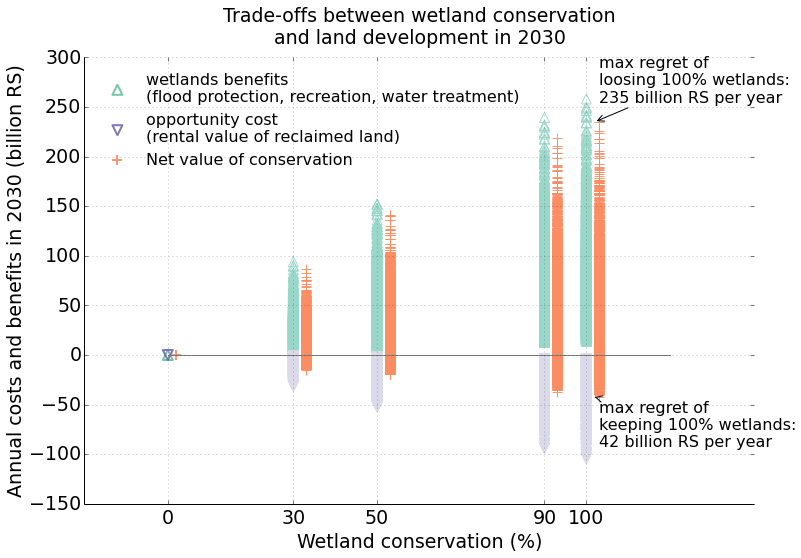

In [13]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(12,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (new_losses.climate_change>0)
grouped = new_losses.ix[select,:].groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="opportunity cost\n(rental value of reclaimed land)")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.17,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)+3]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
       
    
    if i==4:
        ax.annotate("max regret of\nkeeping {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-50), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"),fontsize=16)
        
        ax.annotate("max regret of\nloosing 100% wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+20), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                    fontsize=16
                    )
        
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
#ax.set_xlim([0,120])
#ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Trade-offs between wetland conservation\nand land development in 2030",\
         y=1.02,fontsize=19)

plt.savefig("report/min_max_regret_wetlands_rev.png",bbox_inches="tight",dpi=100)

In [134]:
from lib_for_prim import *

In [199]:
select = (new_losses.wetland_preserv==30)
sousgroup = new_losses.ix[select,:].copy()
experiments=sousgroup[indx1].copy()
outcomes=sousgroup[['npv']].copy()
outcomes['pos']=0+(outcomes['npv']>0)
outcomes['neg']=0+(outcomes['npv']<0)

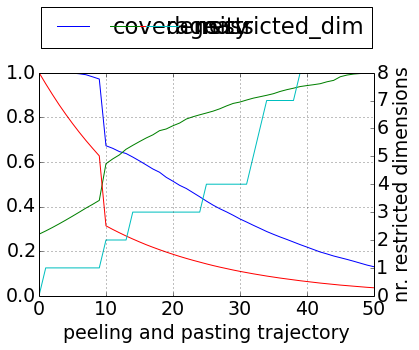

In [200]:
forprim=format_data(outcomes,experiments,"neg")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [202]:
box.inspect(15)

coverage    0.604469
density     0.690821
mass        0.241500
mean        0.690821
res dim     3.000000
Name: 15, dtype: float64

                  box 15                          
                     min        max      qp values
sh_soc          0.517236   0.999733  5.592239e-296
bndconditions   0.000000   0.500000  6.801887e-135
benef_wetlands  6.904409  21.161114   8.478765e-07



In [138]:
experiments.describe()

,climate_change,runoff,bndconditions,pop_gr,gdp_gr,losses_share,resilience,sh_soc,scarcity,benef_wetlands,benef_land
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,1.000000,0.500000,0.500000,0.015000,0.035000,0.174999,0.599998,0.550006,1.500005,19.550099,39.100018
std,0.816519,0.081652,0.500014,0.008660,0.020207,0.072173,0.115474,0.259822,0.288666,7.303635,2.655783
min,0.000000,0.400000,0.000000,0.000002,0.000002,0.050144,0.400058,0.100232,1.000748,6.906928,34.501570
25%,0.000000,0.400000,0.000000,0.007506,0.017498,0.112533,0.500090,0.325424,1.250082,13.239153,36.802330
50%,1.000000,0.500000,0.500000,0.015003,0.035009,0.174971,0.600079,0.549916,1.499871,19.540790,39.100174
75%,2.000000,0.600000,1.000000,0.022491,0.052503,0.237413,0.699894,0.774803,1.749896,25.858904,41.397222
max,2.000000,0.600000,1.000000,0.029999,0.069952,0.299920,0.799620,0.999733,1.999266,32.180170,43.692022


In [294]:
compare = read_csv("data_cba/lakes-vs-wetlands.csv")

In [295]:
compare = compare.set_index("Unnamed: 0")
compare.index = [s.replace(" ","\n") for s in compare.index]

In [296]:
compare.ix["Net value",:] = compare.sum()
compare = compare/144

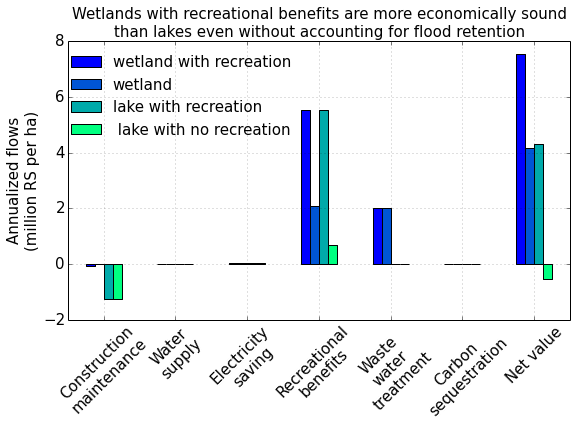

In [300]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

compare.plot(kind='bar',colormap="winter",figsize=(9,5),legend=False)
plt.legend(frameon=False,bbox_to_anchor=[-0.03,0.5,0.5,0.5],fontsize=15)
plt.xlabel("")
plt.ylabel("Annualized flows\n(million RS per ha)")
plt.xticks(rotation=45)
plt.grid(which='major', alpha=0.5)

plt.title("Wetlands with recreational benefits are more economically sound\nthan lakes even without accounting for flood retention",fontsize=15)

plt.savefig("lakes_vs_wetlands",bbox_inches="tight",dpi=400)

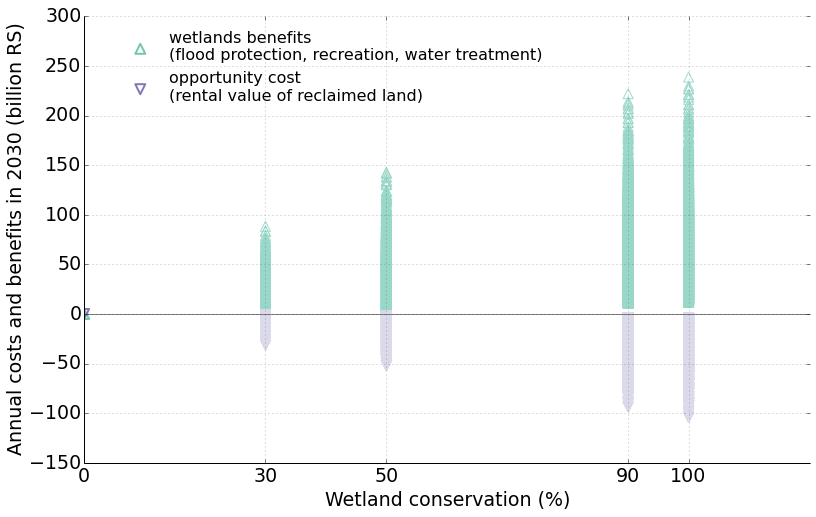

In [203]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

grouped = new_losses.groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="opportunity cost\n(rental value of reclaimed land)")

ax.legend(bbox_to_anchor=[0.15,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
        
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-150,300])

plt.ylabel('Annual costs and benefits in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.savefig("ppt/min_max_regret_wetlands2030_0.png",bbox_inches="tight",dpi=400)

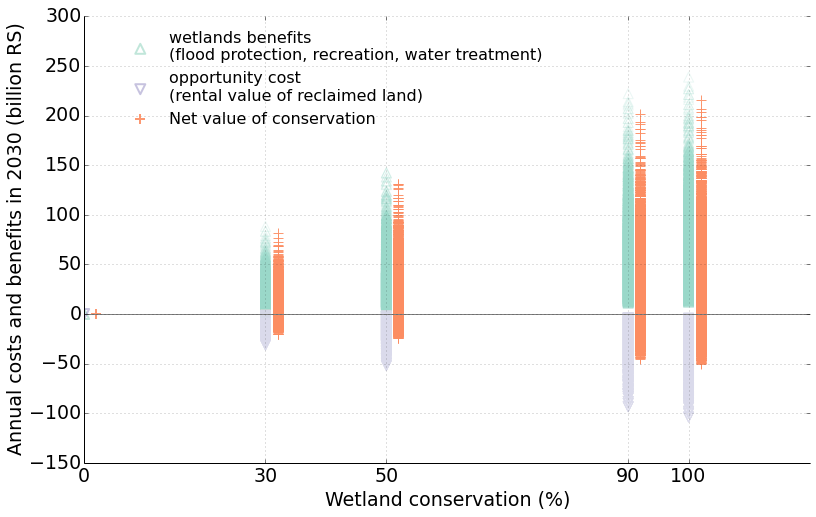

In [204]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

grouped = new_losses.groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.4,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.4,\
                label="opportunity cost\n(rental value of reclaimed land)")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.15,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.2)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.2)
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
       

plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-150,300])

plt.ylabel('Annual costs and benefits in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands2030_1.png",bbox_inches="tight",dpi=400)

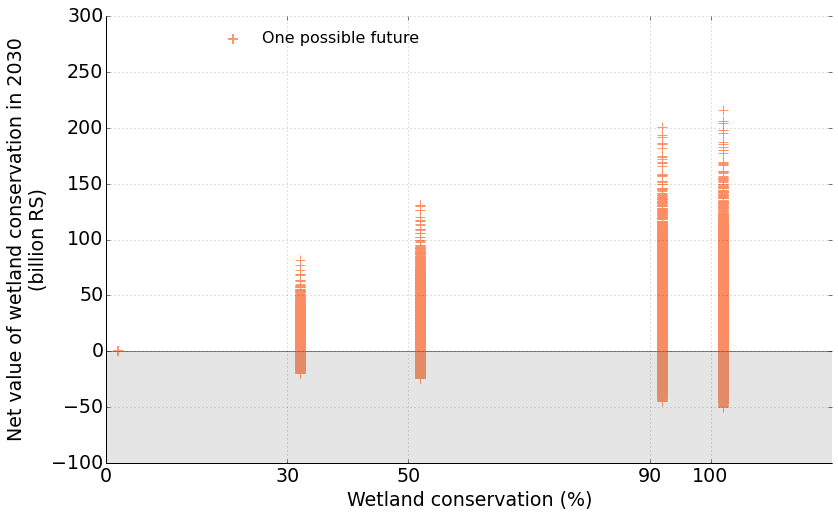

In [209]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

grouped = new_losses.groupby("wetland_preserv")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="One possible future")

ax.legend(bbox_to_anchor=[-0.05,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)

plt.xticks([0,30,50,90,100])

ax.fill_between([0,120], 0, -300,facecolor='grey',alpha=0.2)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-100,300])

plt.ylabel('Net value of wetland conservation in 2030\n(billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands2030_2.png",bbox_inches="tight",dpi=400)

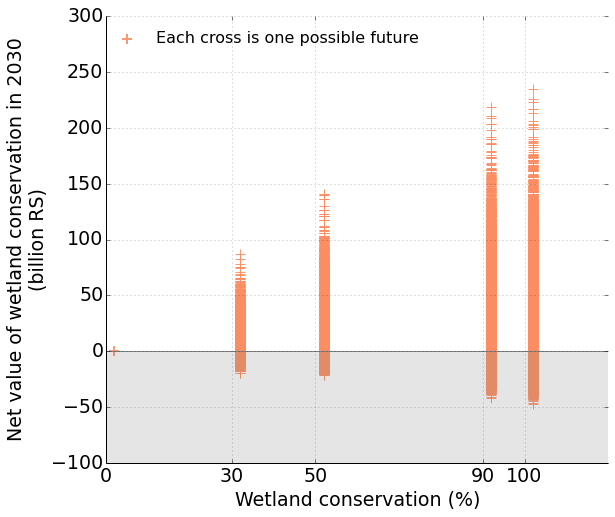

In [24]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(9,8))

ax=plt.subplot(111)

grouped = new_losses.groupby("wetland_preserv")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Each cross is one possible future")

ax.legend(bbox_to_anchor=[0.15,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)

plt.xticks([0,30,50,90,100])

ax.fill_between([0,120], 0, -300,facecolor='grey',alpha=0.2)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-100,300])

plt.ylabel('Net value of wetland conservation in 2030\n(billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands2030_2_paper.png",bbox_inches="tight",dpi=400)

In [1]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

grouped = new_losses.groupby("wetland_preserv")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.05,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
    if i==4:
        ax.annotate("max regret of\nkeeping {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+5,min(yn)-50), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"),fontsize=16)
        
        ax.annotate("max regret of\nloosing 100% wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+20), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                    fontsize=16
                    )

plt.xticks([0,30,50,90,100])

ax.fill_between([0,120], 0, -300,facecolor='grey',alpha=0.2)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-100,300])

plt.ylabel('Net value of wetland conservation in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig("ppt/min_max_regret_wetlands2030_3.png",bbox_inches="tight",dpi=400)

NameError: name 'plt' is not defined

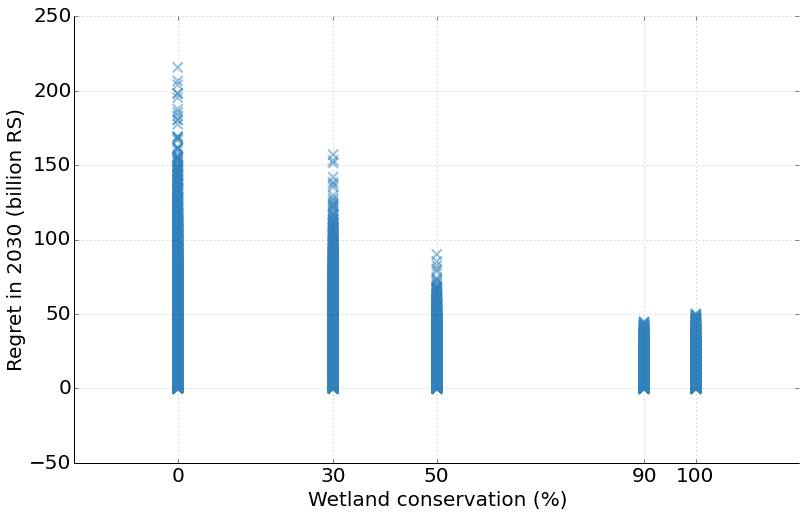

In [188]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

grouped = regret.groupby("wetland_preserv")

#ax.fill_between([50,90], 0, 120, color='#d9d9d9', alpha=0.5)

for i, (name, group) in enumerate(grouped):
    y1 = group.ix[:,"regret"]
    plt.scatter([int(name)]*len(y1),-y1,\
               marker='x',facecolors='none',edgecolors='#3182bd',linewidth='2',s=100,alpha=0.5)
    
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

plt.ylabel('Regret in 2030 (billion RS)')
plt.xlabel('Wetland conservation (%)')

#ax.set_ylim([0,400])

#plt.annotate("More analysis\nneeded here",xy=(52,56))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/max_regret_criteria2030.png",bbox_inches="tight",dpi=400)

In [305]:
(160*10**3*2.3*10**6)*10**(-9)

368.0

In [306]:
5/368

0.01358695652173913